In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from nltk.tokenize import sent_tokenize, word_tokenize
from textblob import TextBlob
from surprise import SVD
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import train_test_split
import gc
from surprise import accuracy
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV

In [2]:
data_reviews= pd.read_csv('C:\\Users\\Tati\\source\\repos\\acamica-datasets\\data_reviews.csv')

In [3]:
import gzip
import pandas as pd

def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)
        
data_games = []
for l in parse('C:\\Users\\Tati\\source\\repos\\acamica-datasets\steam_games.json.gz'):
        data_games.append(l)

In [4]:
data_games = pd.DataFrame(data_games)

### DESCRIPCIÓN DE FEATURES DATA_REVIEWS
username: Nombre del usuario que ha dejado la reseña

hours: Cantidad de horas jugadas (acumuladas) en el juego al cual se le ha hecho la reseña

products: Cantidad de otros juegos probados

product_id: Identificacion númerica del juego reseñado

page_order: Número de página en el cual se encuentra el juego dentro de la plataforma

date: Fecha en la cual se ha creado la reseña

text: Comentario sobre el juego

early_access: Si es True significa que el juego puede ser adquirido durante su etapa de desarrollo

page: No es interpretable

user_id: Identificacion númerica del usuario creador de la reseña

found_funny: Cantidad de calificaciones positivas creadas por otros usuarios

compensation: Variable no interpretable dada la cantidad de valores nulos contenidos en ella

In [5]:
data_reviews.head()

,Unnamed: 0,username,hours,products,product_id,page_order,date,text,early_access,page,found_funny,compensation,user_id
0,0,Chaos Syren,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,NaN,NaN
1,1,₮ʜᴇ Wᴀʀᴛᴏɴ,51.1,769.0,328100,0,2017-12-27,looks like a facebook game,False,1,NaN,NaN,NaN
2,2,hello?<,14.6,2.0,328100,1,2017-10-16,Better than Minecraft,False,1,2.0,Product received for free,NaN
3,3,Cyderine916,5.0,64.0,35140,0,2018-01-04,I love and idolized Batman and this game is Ma...,False,1,NaN,NaN,NaN
4,4,DarklyThinking,16.6,577.0,35140,1,2018-01-04,Still worth playing in 2018.\nProbably my favo...,False,1,NaN,NaN,7.656120e+16


### DESCRIPCIÓN DE FEATURES INCLUIDOS EN DATA_GAMES
desarrollador: Creador del juego

genres: Géneros, caracteristicas del juego

app_name: Editor del juego

title: Nombre del juego

url: Dirección web donde encontrarlo

release_date: Fecha de lanzamiento

tags: Etiquetas relacionadas con el juego

discount_price: Precio con descuento incluido

reviews_url: Dirección web donde encontrar las reseñas sobre el juego

specs: Especificaciones

price: Precio sin descuento

early_access: Si es True significa que el juego puede ser adquirido durante su etapa de desarrollo

id: Identificacion númerica del juego publicado

sentiment: Emoción promedio generada en los usuarios

metascore: Puntaje promedio recibido por los usuarios

In [6]:
data_games.head()

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290,Poolians.com,Mostly Positive,NaN
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",0.83,http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.99,False,767400,彼岸领域,NaN,NaN
4,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,"[Action, Indie, Casual, Sports]",1.79,http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",2.99,False,773570,NaN,NaN,NaN


### Analisis exploratorio DATA_REVIEWS

In [7]:
data_reviews.shape

(7793069, 13)

In [8]:
data_reviews.loc[:,['hours','products']].describe().round(2)

,hours,products
count,7766532.00,7778108.00
mean,111.84,236.48
std,392.86,485.79
min,0.00,1.00
25%,4.00,45.00
50%,15.30,110.00
75%,59.70,246.00
max,42100.70,18188.00


In [9]:
data_reviews.isna().sum()

Unnamed: 0            0
username            208
hours             26537
products          14961
product_id            0
page_order            0
date                  0
text              17972
early_access          0
page                  0
found_funny     6592313
compensation    7647446
user_id         4616846
dtype: int64

In [10]:
data_reviews2=data_reviews[(data_reviews.products>15) & (data_reviews.products<120)]
data_reviews3=data_reviews2[(data_reviews2.hours>4) & (data_reviews2.hours<40)]
#del data_reviews

In [11]:
data_reviews3.head(10)

,Unnamed: 0,username,hours,products,product_id,page_order,date,text,early_access,page,found_funny,compensation,user_id
3,3,Cyderine916,5.0,64.0,35140,0,2018-01-04,I love and idolized Batman and this game is Ma...,False,1,NaN,NaN,NaN
15,15,Duha Nubie,11.3,73.0,35140,4,2018-01-03,first debut feel sweet,False,1,NaN,NaN,NaN
16,16,The Undead StalkeR,17.0,87.0,35140,5,2018-01-03,9/10\nEven after all these years. this game re...,False,1,NaN,NaN,7.656120e+16
29,29,Lxsd-,6.4,88.0,620900,1,2017-11-04,Witchinour is an awesome rogue-like. Faced pac...,False,1,NaN,NaN,7.656120e+16
32,32,Mono,14.1,54.0,506510,1,2017-12-27,A Charming game with colourful pixel graphics ...,False,1,NaN,NaN,7.656120e+16
39,39,xiodeni,18.4,18.0,35140,6,2018-01-03,I definitely recommend this game. I absolutely...,False,1,NaN,NaN,NaN
40,40,the_maker988,8.2,18.0,35140,7,2018-01-02,"This game was way to linear for me, and compar...",False,1,NaN,NaN,7.656120e+16
57,57,Uncle-Noob,24.7,37.0,350280,3,2018-01-04,"I really like this game, but no one plays it. ...",False,1,NaN,NaN,NaN
83,83,WindySilver,11.2,75.0,431320,3,2016-06-04,"Edit: Having a good laptop for gaming now, I'v...",False,1,NaN,NaN,NaN
93,93,★Spoder Man★™,9.0,52.0,365560,2,2017-04-16,A Very Strategic Game :D,False,1,NaN,NaN,NaN


In [12]:
data_reviews3.hours.isna().sum()

0

<AxesSubplot:xlabel='products'>

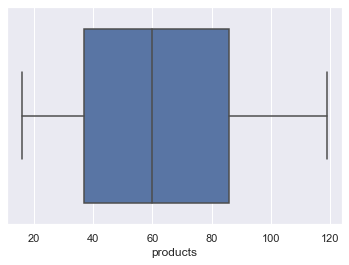

In [13]:
sns.boxplot(x = data_reviews3.products)

<AxesSubplot:xlabel='hours'>

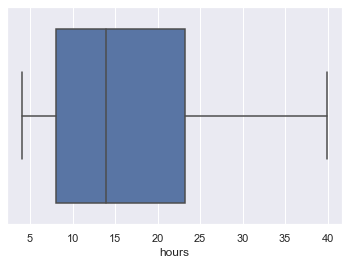

In [14]:
sns.boxplot(x = data_reviews3.hours)

<AxesSubplot:xlabel='products', ylabel='Density'>

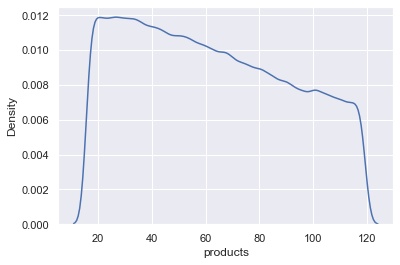

In [15]:
sns.kdeplot(data=data_reviews3.products)

<AxesSubplot:xlabel='hours', ylabel='Density'>

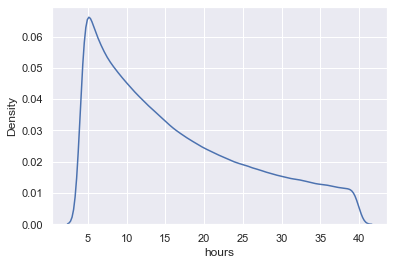

In [16]:
sns.kdeplot(data=data_reviews3.hours)

#### Para completar el analisis exploratorio:
1. Que cantidad de reviews deja en promedio cada usuario?
2. Dentro de los limites establecidos, cual fue el usuario que mas reviews dejo y cual el que menos dejo?
3. Cual es el juego que mas reviews tuvo? cual el que menos reviews tuvo?

In [17]:
data_reviews3.head(9090).username.value_counts().mean()

1.045067831685445

In [18]:
data_reviews3.username.value_counts().describe()

count    728407.000000
mean          1.923772
std           2.969019
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         323.000000
Name: username, dtype: float64

(0.0, 10.0)

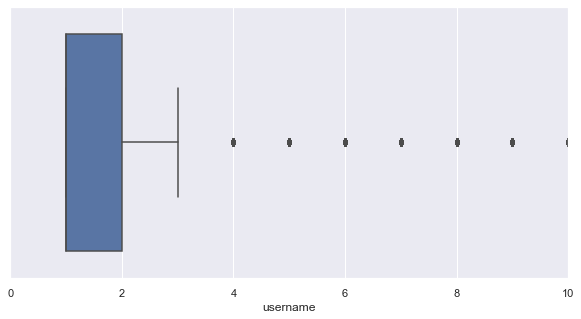

In [19]:
plt.figure(figsize=(10, 5))
ax = sns.boxplot(x=data_reviews3.username.value_counts())
ax.set_xlim([0,10])

In [20]:
data_games['title'].unique().shape

(30055,)

In [21]:
data_games.url

0        http://store.steampowered.com/app/761140/Lost_...
1        http://store.steampowered.com/app/643980/Ironb...
2        http://store.steampowered.com/app/670290/Real_...
3           http://store.steampowered.com/app/767400/2222/
4        http://store.steampowered.com/app/773570/Log_C...
                               ...                        
32130    http://store.steampowered.com/app/773640/Colon...
32131    http://store.steampowered.com/app/733530/LOGis...
32132    http://store.steampowered.com/app/610660/Russi...
32133    http://store.steampowered.com/app/658870/EXIT_...
32134    http://store.steampowered.com/app/681550/Maze_...
Name: url, Length: 32135, dtype: object

In [22]:
data_games.drop_duplicates(subset ="id",
                     keep = False, inplace = True)

In [23]:
data_games.shape # 32135

(32131, 16)

In [24]:
data_games.id.unique().size

32131

In [25]:
data_games.isna().sum()

publisher          8051
genres             3282
app_name              1
title              2049
url                   0
release_date       2066
tags                162
discount_price    31907
reviews_url           0
specs               669
price              1377
early_access          0
id                    0
developer          3298
sentiment          7181
metascore         29457
dtype: int64

In [26]:
data_games[data_games.title.isna()]

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
4,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,"[Action, Indie, Casual, Sports]",1.79,http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",2.99,False,773570,NaN,NaN,NaN
11,NaN,NaN,Icarus Six Sixty Six,NaN,http://store.steampowered.com/app/724910/Icaru...,NaN,[Casual],NaN,http://steamcommunity.com/app/724910/reviews/?...,"[Single-player, HTC Vive, Tracked Motion Contr...",Free,False,724910,NaN,NaN,NaN
19,NaN,NaN,After Life VR,NaN,http://store.steampowered.com/app/772590/After...,NaN,"[Early Access, Indie, VR]",NaN,http://steamcommunity.com/app/772590/reviews/?...,"[Single-player, HTC Vive, Tracked Motion Contr...",4.99,True,772590,NaN,NaN,NaN
20,NaN,NaN,Kitty Hawk,NaN,http://store.steampowered.com/app/640250/Kitty...,NaN,"[Early Access, Action, Adventure, Indie, Casual]",1.97,http://steamcommunity.com/app/640250/reviews/?...,"[Single-player, Steam Leaderboards, HTC Vive, ...",2.99,True,640250,NaN,NaN,NaN
22,NaN,NaN,Mortars VR,NaN,http://store.steampowered.com/app/711440/Morta...,NaN,"[Early Access, Strategy, Action, Indie, Casual...",0.89,http://steamcommunity.com/app/711440/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",0.99,True,711440,NaN,8 user reviews,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32073,NaN,NaN,Tank of War-VR,NaN,http://store.steampowered.com/app/745900/Tank_...,NaN,"[Action, Massively Multiplayer, Strategy, VR, ...",NaN,http://steamcommunity.com/app/745900/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",19.99,False,745900,NaN,3 user reviews,NaN
32076,NaN,NaN,Flappy Arms,NaN,http://store.steampowered.com/app/764110/Flapp...,NaN,"[Casual, Simulation, VR, Funny, Colorful, Come...",1.49,http://steamcommunity.com/app/764110/reviews/?...,"[Single-player, Steam Leaderboards, HTC Vive, ...",1.99,False,764110,NaN,3 user reviews,NaN
32077,NaN,NaN,SpaceWalker,NaN,http://store.steampowered.com/app/705860/Space...,NaN,"[Early Access, Casual]",NaN,http://steamcommunity.com/app/705860/reviews/?...,"[Single-player, HTC Vive, Oculus Rift, Tracked...",Free,True,705860,NaN,2 user reviews,NaN
32085,NaN,NaN,LIV Client,NaN,http://store.steampowered.com/app/755540/LIV_C...,NaN,"[Video Production, Utilities, Web Publishing]",NaN,http://steamcommunity.com/app/755540/reviews/?...,"[Steam Workshop, Steam Cloud, HTC Vive, Oculus...",NaN,False,755540,NaN,NaN,NaN


In [27]:
data_games2 = data_games.reset_index()

In [28]:
url_splited = data_games2.url.str.split('/')

In [29]:
url_splited2 = url_splited.reset_index()


In [30]:
len(data_games2)

32131

In [31]:
len(url_splited2)

32131

In [32]:
data_games2.iloc[32129]

index                                                         32133
publisher                                                  SIXNAILS
genres                                              [Casual, Indie]
app_name                                        EXIT 2 - Directions
title                                           EXIT 2 - Directions
url               http://store.steampowered.com/app/658870/EXIT_...
release_date                                             2017-09-02
tags              [Indie, Casual, Puzzle, Singleplayer, Atmosphe...
discount_price                                                  NaN
reviews_url       http://steamcommunity.com/app/658870/reviews/?...
specs              [Single-player, Steam Achievements, Steam Cloud]
price                                                          4.99
early_access                                                  False
id                                                           658870
developer                                       

In [33]:
data_games2.iloc[32129].url

'http://store.steampowered.com/app/658870/EXIT_2__Directions/'

In [34]:
url_splited[32129]

['http:',
 '',
 'store.steampowered.com',
 'app',
 '658870',
 'EXIT_2__Directions',
 '']

In [36]:
resultados = []
data_games2["URL_NAME"] = ""
k=0
m = 5
for i in url_splited2.url:
    data_games2["URL_NAME"][k] = i[m]
    resultados.append(i[m])
    k=k+1
k=0
    
len(resultados)

<ipython-input-36-81069d3c00d9>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_games2["URL_NAME"][k] = i[m]


32131

In [39]:
data_games2.URL_NAME.isna().sum()

0

In [40]:
url_splited2

,index,url
0,0,"[http:, , store.steampowered.com, app, 761140,..."
1,1,"[http:, , store.steampowered.com, app, 643980,..."
2,2,"[http:, , store.steampowered.com, app, 670290,..."
3,3,"[http:, , store.steampowered.com, app, 767400,..."
4,4,"[http:, , store.steampowered.com, app, 773570,..."
...,...,...
32126,32126,"[http:, , store.steampowered.com, app, 773640,..."
32127,32127,"[http:, , store.steampowered.com, app, 733530,..."
32128,32128,"[http:, , store.steampowered.com, app, 610660,..."
32129,32129,"[http:, , store.steampowered.com, app, 658870,..."


In [41]:
data_games2[data_games2.title.isna()]

,index,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore,URL_NAME
4,4,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,"[Action, Indie, Casual, Sports]",1.79,http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",2.99,False,773570,NaN,NaN,NaN,Log_Challenge
11,11,NaN,NaN,Icarus Six Sixty Six,NaN,http://store.steampowered.com/app/724910/Icaru...,NaN,[Casual],NaN,http://steamcommunity.com/app/724910/reviews/?...,"[Single-player, HTC Vive, Tracked Motion Contr...",Free,False,724910,NaN,NaN,NaN,Icarus_Six_Sixty_Six
19,19,NaN,NaN,After Life VR,NaN,http://store.steampowered.com/app/772590/After...,NaN,"[Early Access, Indie, VR]",NaN,http://steamcommunity.com/app/772590/reviews/?...,"[Single-player, HTC Vive, Tracked Motion Contr...",4.99,True,772590,NaN,NaN,NaN,After_Life_VR
20,20,NaN,NaN,Kitty Hawk,NaN,http://store.steampowered.com/app/640250/Kitty...,NaN,"[Early Access, Action, Adventure, Indie, Casual]",1.97,http://steamcommunity.com/app/640250/reviews/?...,"[Single-player, Steam Leaderboards, HTC Vive, ...",2.99,True,640250,NaN,NaN,NaN,Kitty_Hawk
22,22,NaN,NaN,Mortars VR,NaN,http://store.steampowered.com/app/711440/Morta...,NaN,"[Early Access, Strategy, Action, Indie, Casual...",0.89,http://steamcommunity.com/app/711440/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",0.99,True,711440,NaN,8 user reviews,NaN,Mortars_VR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32069,32073,NaN,NaN,Tank of War-VR,NaN,http://store.steampowered.com/app/745900/Tank_...,NaN,"[Action, Massively Multiplayer, Strategy, VR, ...",NaN,http://steamcommunity.com/app/745900/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",19.99,False,745900,NaN,3 user reviews,NaN,Tank_of_WarVR
32072,32076,NaN,NaN,Flappy Arms,NaN,http://store.steampowered.com/app/764110/Flapp...,NaN,"[Casual, Simulation, VR, Funny, Colorful, Come...",1.49,http://steamcommunity.com/app/764110/reviews/?...,"[Single-player, Steam Leaderboards, HTC Vive, ...",1.99,False,764110,NaN,3 user reviews,NaN,Flappy_Arms
32073,32077,NaN,NaN,SpaceWalker,NaN,http://store.steampowered.com/app/705860/Space...,NaN,"[Early Access, Casual]",NaN,http://steamcommunity.com/app/705860/reviews/?...,"[Single-player, HTC Vive, Oculus Rift, Tracked...",Free,True,705860,NaN,2 user reviews,NaN,SpaceWalker
32081,32085,NaN,NaN,LIV Client,NaN,http://store.steampowered.com/app/755540/LIV_C...,NaN,"[Video Production, Utilities, Web Publishing]",NaN,http://steamcommunity.com/app/755540/reviews/?...,"[Steam Workshop, Steam Cloud, HTC Vive, Oculus...",NaN,False,755540,NaN,NaN,NaN,LIV_Client


In [42]:
data_games2.loc[:, ["title", "URL_NAME"]].tail(5)

,title,URL_NAME
32126,Colony On Mars,Colony_On_Mars
32127,LOGistICAL: South Africa,LOGistICAL_South_Africa
32128,Russian Roads,Russian_Roads
32129,EXIT 2 - Directions,EXIT_2__Directions
32130,NaN,Maze_Run_VR


In [43]:
data_reviews3.head()

,Unnamed: 0,username,hours,products,product_id,page_order,date,text,early_access,page,found_funny,compensation,user_id
3,3,Cyderine916,5.0,64.0,35140,0,2018-01-04,I love and idolized Batman and this game is Ma...,False,1,NaN,NaN,NaN
15,15,Duha Nubie,11.3,73.0,35140,4,2018-01-03,first debut feel sweet,False,1,NaN,NaN,NaN
16,16,The Undead StalkeR,17.0,87.0,35140,5,2018-01-03,9/10\nEven after all these years. this game re...,False,1,NaN,NaN,7.656120e+16
29,29,Lxsd-,6.4,88.0,620900,1,2017-11-04,Witchinour is an awesome rogue-like. Faced pac...,False,1,NaN,NaN,7.656120e+16
32,32,Mono,14.1,54.0,506510,1,2017-12-27,A Charming game with colourful pixel graphics ...,False,1,NaN,NaN,7.656120e+16


In [33]:
data_games2[data_games2.title == "Colony On Mars"]

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore,URL_NAME
32130,Ghost_RUS Games,"[Casual, Indie, Simulation, Strategy]",Colony On Mars,Colony On Mars,http://store.steampowered.com/app/773640/Colon...,2018-01-04,"[Strategy, Indie, Casual, Simulation]",1.49,http://steamcommunity.com/app/773640/reviews/?...,"[Single-player, Steam Achievements]",1.99,False,773640,"Nikita ""Ghost_RUS""",NaN,NaN,Maze_Run_VR


In [45]:
data_reviews_to_export = data_reviews3.loc[:,["username","product_id", "hours", "products"]]

In [47]:
data_reviews_to_export["game_name"] = ""

In [48]:
data_reviews_to_export

,username,product_id,hours,products,game_name
3,Cyderine916,35140,5.0,64.0,
15,Duha Nubie,35140,11.3,73.0,
16,The Undead StalkeR,35140,17.0,87.0,
29,Lxsd-,620900,6.4,88.0,
32,Mono,506510,14.1,54.0,
...,...,...,...,...,...
7792974,Kayrik,252490,29.7,64.0,
7792989,alaskan bull worm,252490,17.6,83.0,
7792994,DiaboDiaboDiabo,252490,6.3,92.0,
7792998,StealthCharm,252490,9.7,88.0,


In [76]:
data_games2.id= pd.to_numeric(data_games2.id,downcast='integer')

In [81]:
data_reviews_to_export = pd.merge(left=pd.DataFrame(data_reviews_to_export),right=data_games2, left_on='product_id', right_on='id')

In [82]:
data_reviews_to_export

,username,product_id,hours,products,game_name,index_x,publisher_x,genres_x,app_name_x,title_x,...,discount_price_y,reviews_url_y,specs_y,price_y,early_access_y,id_y,developer_y,sentiment_y,metascore_y,URL_NAME_y
0,Cyderine916,35140,5.0,64.0,,31617,"Warner Bros. Interactive Entertainment, Feral ...","[Action, Adventure]",Batman: Arkham Asylum Game of the Year Edition,Batman: Arkham Asylum Game of the Year Edition,...,NaN,http://steamcommunity.com/app/35140/reviews/?b...,"[Single-player, Steam Achievements, Steam Trad...",19.99,False,35140,"Rocksteady Studios,Feral Interactive (Mac)",Overwhelmingly Positive,91,Batman_Arkham_Asylum_Game_of_the_Year_Edition
1,Duha Nubie,35140,11.3,73.0,,31617,"Warner Bros. Interactive Entertainment, Feral ...","[Action, Adventure]",Batman: Arkham Asylum Game of the Year Edition,Batman: Arkham Asylum Game of the Year Edition,...,NaN,http://steamcommunity.com/app/35140/reviews/?b...,"[Single-player, Steam Achievements, Steam Trad...",19.99,False,35140,"Rocksteady Studios,Feral Interactive (Mac)",Overwhelmingly Positive,91,Batman_Arkham_Asylum_Game_of_the_Year_Edition
2,The Undead StalkeR,35140,17.0,87.0,,31617,"Warner Bros. Interactive Entertainment, Feral ...","[Action, Adventure]",Batman: Arkham Asylum Game of the Year Edition,Batman: Arkham Asylum Game of the Year Edition,...,NaN,http://steamcommunity.com/app/35140/reviews/?b...,"[Single-player, Steam Achievements, Steam Trad...",19.99,False,35140,"Rocksteady Studios,Feral Interactive (Mac)",Overwhelmingly Positive,91,Batman_Arkham_Asylum_Game_of_the_Year_Edition
3,xiodeni,35140,18.4,18.0,,31617,"Warner Bros. Interactive Entertainment, Feral ...","[Action, Adventure]",Batman: Arkham Asylum Game of the Year Edition,Batman: Arkham Asylum Game of the Year Edition,...,NaN,http://steamcommunity.com/app/35140/reviews/?b...,"[Single-player, Steam Achievements, Steam Trad...",19.99,False,35140,"Rocksteady Studios,Feral Interactive (Mac)",Overwhelmingly Positive,91,Batman_Arkham_Asylum_Game_of_the_Year_Edition
4,the_maker988,35140,8.2,18.0,,31617,"Warner Bros. Interactive Entertainment, Feral ...","[Action, Adventure]",Batman: Arkham Asylum Game of the Year Edition,Batman: Arkham Asylum Game of the Year Edition,...,NaN,http://steamcommunity.com/app/35140/reviews/?b...,"[Single-player, Steam Achievements, Steam Trad...",19.99,False,35140,"Rocksteady Studios,Feral Interactive (Mac)",Overwhelmingly Positive,91,Batman_Arkham_Asylum_Game_of_the_Year_Edition
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1399589,rt974,518790,9.4,36.0,,8781,Avalanche Studios,"[Adventure, Simulation, Sports]",theHunter: Call of the Wild™,theHunter: Call of the Wild™,...,NaN,http://steamcommunity.com/app/518790/reviews/?...,"[Single-player, Multi-player, Steam Achievemen...",29.99,False,518790,Expansive Worlds,Mostly Positive,NaN,theHunter_Call_of_the_Wild
1399590,Zevy ツ,518790,35.4,70.0,,8781,Avalanche Studios,"[Adventure, Simulation, Sports]",theHunter: Call of the Wild™,theHunter: Call of the Wild™,...,NaN,http://steamcommunity.com/app/518790/reviews/?...,"[Single-player, Multi-player, Steam Achievemen...",29.99,False,518790,Expansive Worlds,Mostly Positive,NaN,theHunter_Call_of_the_Wild
1399591,Ampun Sultan,518790,13.6,62.0,,8781,Avalanche Studios,"[Adventure, Simulation, Sports]",theHunter: Call of the Wild™,theHunter: Call of the Wild™,...,NaN,http://steamcommunity.com/app/518790/reviews/?...,"[Single-player, Multi-player, Steam Achievemen...",29.99,False,518790,Expansive Worlds,Mostly Positive,NaN,theHunter_Call_of_the_Wild
1399592,GuDDo,518790,16.7,22.0,,8781,Avalanche Studios,"[Adventure, Simulation, Sports]",theHunter: Call of the Wild™,theHunter: Call of the Wild™,...,NaN,http://steamcommunity.com/app/518790/reviews/?...,"[Single-player, Multi-player, Steam Achievemen...",29.99,False,518790,Expansive Worlds,Mostly Positive,NaN,theHunter_Call_of_the_Wild


In [90]:
data_reviews_to_export["game_name"] =  data_reviews_to_export["URL_NAME_y"] 

In [91]:
data_reviews_to_export2 = data_reviews_to_export.loc[:,["username","product_id", "hours", "products", "game_name"]]

In [92]:
data_reviews_to_export2

,username,product_id,hours,products,game_name
0,Cyderine916,35140,5.0,64.0,Batman_Arkham_Asylum_Game_of_the_Year_Edition
1,Duha Nubie,35140,11.3,73.0,Batman_Arkham_Asylum_Game_of_the_Year_Edition
2,The Undead StalkeR,35140,17.0,87.0,Batman_Arkham_Asylum_Game_of_the_Year_Edition
3,xiodeni,35140,18.4,18.0,Batman_Arkham_Asylum_Game_of_the_Year_Edition
4,the_maker988,35140,8.2,18.0,Batman_Arkham_Asylum_Game_of_the_Year_Edition
...,...,...,...,...,...
1399589,rt974,518790,9.4,36.0,theHunter_Call_of_the_Wild
1399590,Zevy ツ,518790,35.4,70.0,theHunter_Call_of_the_Wild
1399591,Ampun Sultan,518790,13.6,62.0,theHunter_Call_of_the_Wild
1399592,GuDDo,518790,16.7,22.0,theHunter_Call_of_the_Wild
